# Housing Price Predictions

#### Joseph Young

As part of the Kaggle Competition "House Prices: Advanced Regression Techniques," this notebook will outline the methods and models I used to produce predictions for Housing Prices. 

My Predictions Place 1435th In the Competition Leaderboard.

## Table of Contents

 > ###    1.   Target Analysis/ Correction
 > ###    2.   Data Analysis/ Description
 > ###    3.   Data Cleaning
 > ###    4.   Train Test Split Methodology
 > ###    5.   Prediction Models/ Optimization
 > ###    6.   Conclusions
 > ###    7.   Citations


In [3]:
#for package access
import sys
sys.path.append(r'R:\JoePriceResearch\Python\Anaconda3\Lib\site-packages')

#for directory navigation
import os

#for data processing/analytics
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import boxcox

#for modeling/ prediction
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns



## 1. Target Analysis/ Correction
In this section I will analyze the Sales Price data alone to ensure it's proper integration into the model.
It proceeds as follows:
 - Reading in the data
 - Creation of a new variable for analysis of the SalePrice target
 - Analysis of the target variable
 - Some corrections to the target data

In [1224]:
#choose working directory
os.chdir(r"C:\Users\josephwy\Documents\all")

In [1225]:
#read training dataset into pandas
train_df = pd.read_csv("train.csv")
#basic overview of data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Notably, the data does not have a variable for Total Square Feet. Because this will be important for analysis of the target variable, I created one below.

In [1226]:
#creates a column of total square feet--sums across all other square foot elements
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

In [1227]:
#gives an overview of the SalePrice Variable
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [1228]:
#returns the number of missing values
print("Number of missing data points: " + str(train_df["SalePrice"].isnull().sum()))

Number of missing data points: 0


### SalePrice Deductions

An inspection of the data revealed the following:
Sales Price data is clean--There are no missing datapoints, and it all reads in properly. 

However, there are a couple things to be noted:
 - There is a skewness of 1.882876, and a kurtosis of 6.536282. 

 - There are outliers in the data which I will show below

In [1229]:
#defines a function to visualize data distribution
def distribution(data, x_axis, y_label, title):
    ax = sns.distplot(data[x_axis])
    ax.set_title(title)
    ax.set_ylabel(y_label)
    plt.show()

In [1230]:
#defines a scatterplot function
def scatterplot(data, x_column, y_column, x_label, y_label, title):
    #determines plot dimensions
    plt.figure(figsize=(10,6))
    #determines plot font size
    plt.rcParams.update({'font.size': 40})
    #inputs data and chooses axis
    plt.scatter(x_column, y_column, data=data)
    #populates axis labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.suptitle(title, fontsize=15)
    plt.show()
    
    return

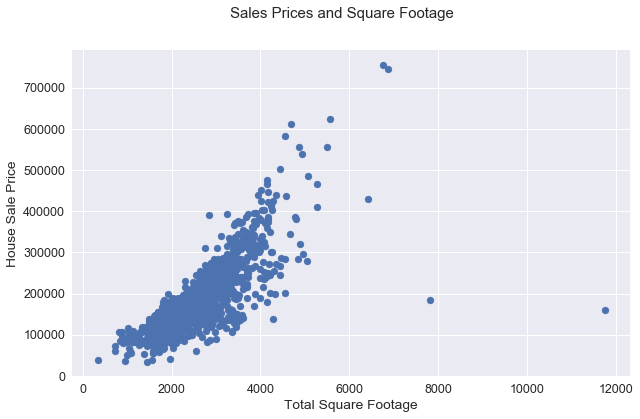

In [1231]:
scatterplot(train_df, "TotalSF", "SalePrice", "Total Square Footage", "House Sale Price", "Sales Prices and Square Footage")

Here we see 2 outliers at roughly 8000 and 12000 sq feet. They are problematic because their huge size deviates heavily from the Sales Price trend which would surely affect OLS estimates. Additionally, there is no other variation in the data following 7800 square ft. 

### Target Corrections
In this section I accomplish 2 things:
 - Skewness treatment
 - Dropping Outliers
 
To correct for Skewness, I tried 2 approaches: the BoxCox Transformation, and a simple natural log tranform.

After comparing skewness and kurtosis on SalePrice using both models, I found that the natural log transformation actual did a better job than the boxcox method (albeit with a high lambda) at reducing skewness. Setting lamda = 0 in the Boxcox model accomplished the exact same thing in principle. But for the sake of simplicity, I chose to use the natural log transformation for SalePrice. 

In [1232]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())
sale_price = train_df['SalePrice']
id_col = train_df["Id"]

Skewness: 0.121335
Kurtosis: 0.809532


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


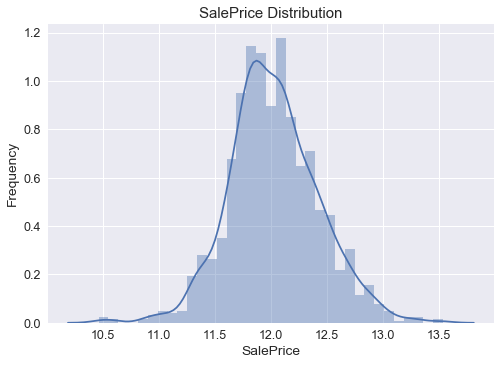

In [1233]:
#plots the SalePrice data distribution 
distribution(train_df, "SalePrice", "Frequency", "SalePrice Distribution")

Next, I drop the outliers:

In [1234]:
#drops outlier houses
train_df = train_df[train_df["TotalSF"] <= 7800]

Here is the new plot without the outliers:

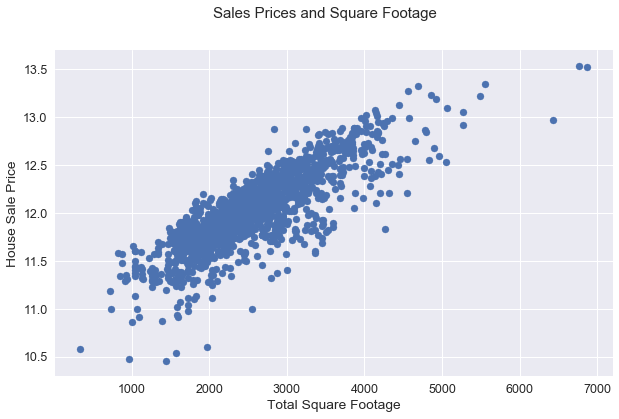

In [1235]:
scatterplot(train_df, "TotalSF", "SalePrice", "Total Square Footage", "House Sale Price", "Sales Prices and Square Footage")

## 2. Data Description/ Cleaning

With the inclusion of the Total Square Footage Variable, there are 82 columns in this dataset. Each data component has to be analyzed to determine whether they are processed/ready to use, and whether they are relevant and appropriate for the prediction.

In this section I accomplish the following
 - Search for and correct missing data
 - Analyze each data column by type and function (including their relationship with Sale Price,)
 - Correlation analysis between data with heat mapping
 - Analyze Categorical Variables/ Create Dummy Variables
 - Create Dummy Variables
 

### Missing Data Discovery and Correction

I will take this step first to ensure that all data is present when I analyze it. 

I divide my features into numeric and categorical categories because they must be approached differently.


In [1236]:
#Creates numeric and categorical feature lists
numeric_features = train_df.dtypes[train_df.dtypes != "object"].index
cat_features = train_df.dtypes[train_df.dtypes == "object"].index
print(len(numeric_features))
print(len(cat_features))

39
43


In [1237]:
#creates lists of missing categorical and numerical data
numeric_missing = []
print("Missing Numeric Data: \n")
for feature in numeric_features:
    if train_df[feature].isnull().sum() > 0:
        numeric_missing.append(feature)
for feature in numeric_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))

print("\nMissing Categorical Data: \n")
cat_missing = []
for feature in cat_features:
    if train_df[feature].isnull().sum() > 0:
        cat_missing.append(feature)
for feature in cat_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))

Missing Numeric Data: 

Missing data points for LotFrontage: 259
Missing data points for MasVnrArea: 8
Missing data points for GarageYrBlt: 81

Missing Categorical Data: 

Missing data points for Alley: 1367
Missing data points for MasVnrType: 8
Missing data points for BsmtQual: 37
Missing data points for BsmtCond: 37
Missing data points for BsmtExposure: 38
Missing data points for BsmtFinType1: 37
Missing data points for BsmtFinType2: 38
Missing data points for Electrical: 1
Missing data points for FireplaceQu: 690
Missing data points for GarageType: 81
Missing data points for GarageFinish: 81
Missing data points for GarageQual: 81
Missing data points for GarageCond: 81
Missing data points for PoolQC: 1452
Missing data points for Fence: 1177
Missing data points for MiscFeature: 1404


In [1238]:
train_df[numeric_missing].head()

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0


In [1239]:
train_df[cat_missing].head()

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,NaN,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN
1,NaN,None,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN
2,NaN,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN
3,NaN,None,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,Unf,TA,TA,NaN,NaN,NaN
4,NaN,BrkFace,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN


#### Missing Categorical Data:

The following features (in the none_list) represent features whose missing values have been given the value "NA," when they really mean to say that the feature (such as a pool, an alley, a fence, etc.) was not present in the house. To resolve this error, I simply replaced "NA" with "None" so that pandas could read it as data. 

In [1240]:
#iterates through list of features, replacing NA with "None"
none_list = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', "MSSubClass", "MasVnrType"]

for feature in none_list:
    train_df[feature] = train_df[feature].fillna("None")

The following features (in the zero_list) represent features whose missing values have been given the value "NA." In these cases, 0 was a more appropriate replacement than "None" for consistency in the data. You'll notice I included the numeric category MaVnrArea because this treatment method seemed appropriate (a 0 signifies the house does not have a masonry veneer). 

In [1241]:
#iterates through list of features, replacing NA with 0
zero_list = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
             'BsmtHalfBath',"MasVnrArea"]
for feature in zero_list:
    train_df[feature] = train_df[feature].fillna(0)

In [1242]:
train_df["MasVnrArea"].head(20)


0     196.0
1       0.0
2     162.0
3       0.0
4     350.0
5       0.0
6     186.0
7     240.0
8       0.0
9       0.0
10      0.0
11    286.0
12      0.0
13    306.0
14    212.0
15      0.0
16    180.0
17      0.0
18      0.0
19      0.0
Name: MasVnrArea, dtype: float64

The following features were missing data points, but an extremely minimal amount (under 5 in most cases). Because I couldn't ascertain what they should be replaced with, I simply used the most common values present in the set. Given the high number of observations and low number of missing data, I don't believe this method will make a significant difference in the data. 

In [1243]:
#iterates through list of features, replacing NA with the most common value
mode_list = ["MSZoning", 'Electrical','KitchenQual','Exterior1st','Exterior2nd', 'SaleType']            
for feature in mode_list:
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])

The Utilities feature is almost entirely uniform, the exceptions being for datapoints not present in the testing set. So I dropped it. It would have had absolutely no predictive capability in the model.

In [1244]:
train_df = train_df.drop(['Utilities'], axis=1)

The final categorical feature with missing data is "Functional." The description identifies "NA" as meaning "Typical"

In [1245]:
train_df["Functional"] = train_df["Functional"].fillna("Typical")

#### Missing Numeric Data:
While I ultimately decided to treat MasVnrArea as a categorical variable, both GarageYrBlt and are unique. Replacing a missing year or a missing lot area with a 0 or a None could misrepresent the data and skew the predictions. Because homes in the same neighborhood often share similar lot sizes, I can impute the missing Lot Frontage data using the respective mean values of other homes in the neighborhood. Similarly, I can impute the missing GarageBuilt data using the average of other homes built in the same year. 

In [1246]:
#iterates through the list of numeric features and imputes missing values with the median of the neighborhood. 
numeric_list = ['GarageYrBlt', "LotFrontage"]

for feature in numeric_list:
    train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
for feature in numeric_list:
    train_df['GarageYrBlt'] = train_df.groupby("Neighborhood")['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
    

### Feature Analysis
In this section I find which features will be most relevant to our model, and isolate highly correlated variables to avoid bias approaching multicolinearity. 


In [1247]:
#Creates a heatmap to compare the top features most correlated with saleprice
def heatmap(data, num_features, primary_feature, title):
    corrmat = data.corr()
    columns = corrmat.nlargest(num_features, primary_feature)[primary_feature].index
    cm = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(14, 10))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    plt.title(title)
    plt.show()
    
    return

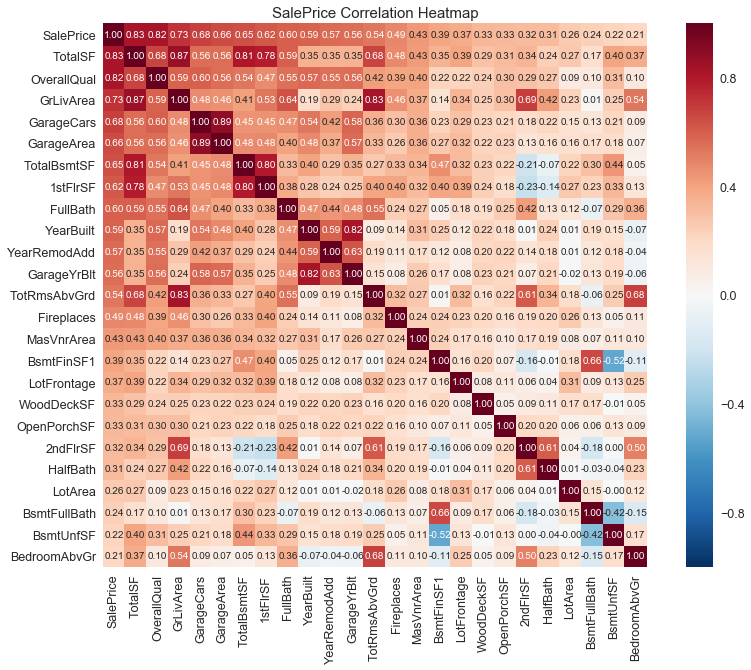

In [1248]:
heatmap(train_df, 25, "SalePrice", "SalePrice Correlation Heatmap")

We see that GrLivArea and TotRmsAbvGrd, 1stFlrFS and TotalBsmtSF, 1stFlrFs and TotalFS, TotalBsmtSF and1stFlrSF, TotalSF and FullBath, and TotalSF and TotalBsmtSF are all highly correlated features. To keep the model clean, I will exclude FullBath, 1stFlrFS, TotalBsmtSF, and TotRmsAbvGrd from some of my prediction models to see if they improve estimates. 

In [1249]:
#listing my take aways from the correlation mapping
high_corr_list = ["TotalSF", "OverallQual", "GrLivArea", "GarageCars","GarageArea", "YearBuilt", "YearRemodAdd", 
                  "GarageYrBlt", "TotRmsAbvGrd", "Fireplaces", "MasVnrArea", "BsmtFinSF1", "LotFrontage", "WoodDeckSF", 
                  "OpenPorchSF", "2ndFlrSF","HalfBath","LotArea","BasmtFullBath","BsmtUnfSF","BedroomAbvGr"]

#### Categorical Feature Analysis

There are many categorical variables in the model, all of which would need to be turned into dummy variables for any parametric analysis. However, there are so many values that simply creating dummies for them would soak up far too many degrees of freedom and dilute the statistical power of the model. This section is devoted to determining which should be used. 

In [1250]:
#
cat_features = ["MSZoning","Street","Alley","LotShape","LandContour","LotConfig","LandSlope","Neighborhood","Condition1",
                "Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType",
                "ExterQual","ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                "Heating","HeatingQC","CentralAir","Electrical","KitchenQual","Functional","FireplaceQu","GarageType",
                "GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence","MiscFeature","SaleType",
                "SaleCondition"]
cat_df = train_df[cat_features]
cat_df = pd.get_dummies(cat_df)
cat_df.head()
cat_df["SalePrice"] = train_df["SalePrice"]


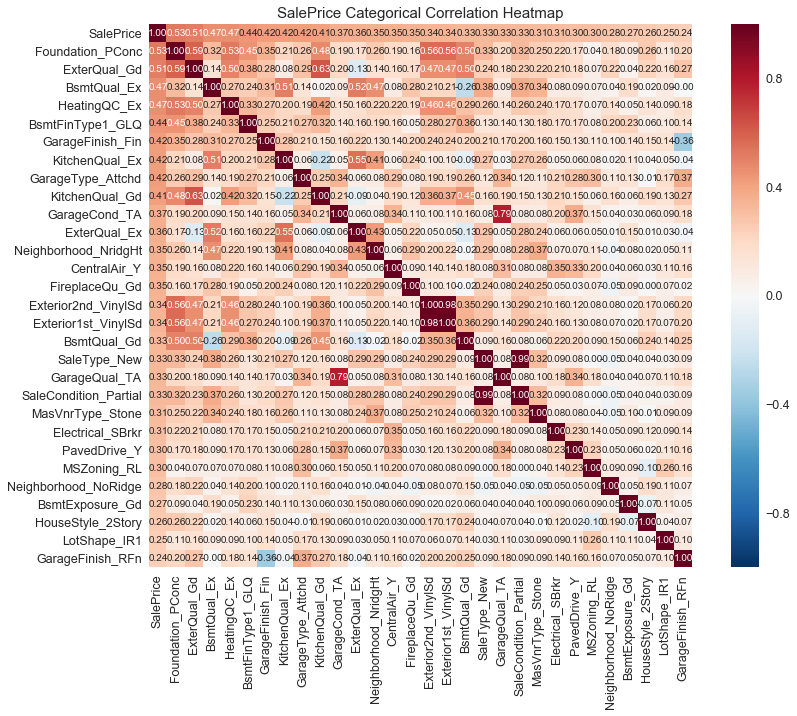

In [1251]:
heatmap(cat_df, 30, "SalePrice", "SalePrice Categorical Correlation Heatmap")

From here we see the most predictive dummy variables. It is also noteworthy that GarageCond_TA is highly correlated with GarageQual_TA which makes a lot of sense. GarageQual_TA will be excluded from my final model since it is so highly correlated with GarageCond_TA, but is not as highly correlated with the target values.

In [1252]:
#makes list of best dummy variables
cat_corrmat = cat_df.corr()
top_dummies = cat_df[cat_corrmat.nlargest(30, "SalePrice")["SalePrice"].index]


In [1253]:
top_dummies.head()


,SalePrice,Foundation_PConc,ExterQual_Gd,BsmtQual_Ex,HeatingQC_Ex,BsmtFinType1_GLQ,GarageFinish_Fin,KitchenQual_Ex,GarageType_Attchd,KitchenQual_Gd,...,SaleCondition_Partial,MasVnrType_Stone,Electrical_SBrkr,PavedDrive_Y,MSZoning_RL,Neighborhood_NoRidge,BsmtExposure_Gd,HouseStyle_2Story,LotShape_IR1,GarageFinish_RFn
0,12.247694,1,1,0,1,1,0,0,1,1,...,0,0,1,1,1,0,0,1,0,1
1,12.109011,0,0,0,1,0,0,0,1,0,...,0,0,1,1,1,0,1,0,0,1
2,12.317167,1,1,0,1,1,0,0,1,1,...,0,0,1,1,1,0,0,1,1,1
3,11.849398,0,0,0,0,0,0,0,0,1,...,0,0,1,1,1,0,0,1,1,0
4,12.429216,1,1,0,1,1,0,0,1,1,...,0,0,1,1,1,1,0,1,1,1


### Correcting Skewness
Much like the target variable, several of the features are skewed. I correct for them individually, choosing the method that reduces skewness the most (boxcox or natural log.)

In [1254]:
#removes SalePrice and Id so they dont get altered
numeric_features.drop("SalePrice")
numeric_features.drop("Id")

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'TotalSF'],
      dtype='object')

In [1255]:
skew_cox_df = train_df[numeric_features]
skew_ln_df = train_df[numeric_features]

In [1256]:
#Corrects for skewness using boxcox. I adapted this from code by Serigne in "Stacked Regressions : Top 4% on LeaderBoard"

for feature in numeric_features:
        train_df[feature] += 1
        train_df[feature] = np.log(train_df[feature])

### Scaling Data
To use Gradient Descent, I scaled my data using the following algorithm:

It mimics the Standard Scaler but I wrote it before I knew the Standard Scaler existed. 

In [1257]:
# creates a new df with normalized numeric data, appends categorical data, and top 30 dummy variables. 
norm_train_df = pd.DataFrame()
#takes the difference in means and divides by the standard deviation
for i in numeric_features:
    norm_train_df[i]= (train_df[i]-train_df[i].mean())/train_df[i].std()
#for i in cat_features:
    #norm_train_df[i]= train_df[i]
for i in top_dummies:
    norm_train_df[i]= cat_df[i]
norm_train_df["Id"]= train_df["Id"]
norm_train_df["Id"] = id_col
norm_train_df["SalePrice"] = sale_price

## Train/Test/Split
Here I split the data into training and testing sets to improve my estimates prior to using the validation set. I used 80% of my data for Training and 20% for testing. 

In [1258]:
#returns saleprice and id to the data for the split
train_df["SalePrice"] = sale_price
train_df["Id"] = id_col


In [1259]:
#splits the data
X_train, X_test, y_train, y_test = train_test_split(norm_train_df, norm_train_df["SalePrice"], test_size=0.2, random_state=42)

## Models
I tried several models to compare fit capabilities. These are all the models I tried:
 - Linear Regression using Gradient Descent
 - Lasso
 - Ridge
 - Elastic Net Regression
 - HuberRegressor 
 - Bayesian Ridge
 
 First I wrote functions for each model. The functions are displayed below, along with the rmse of a preliminary run using default parameters:

### Gradient Descent (For Linear Regression)

In [1260]:
#defines the SGD model function
def lin_regress(data, target_param, lr):
    
    linear_regression_model = SGDRegressor(tol=.0001, eta0=lr)
    linear_regression_model.fit(data, target_param)
    predictions = linear_regression_model.predict(data)
    mse = mean_squared_error(target_param, predictions)
    print("RMSE: {}".format(np.sqrt(mse)))
   
    return(predictions, mse)


In [1261]:
def rmse_comparison(y_vals, y_predictions):
    return np.sqrt(mean_squared_error(y_vals, y_predictions))

##### Preliminary Run

In [1262]:
lin_regress(X_train, y_train, 0.01)

RMSE: 237359596842661.56


(array([7.54591561e+13, 3.00264037e+14, 2.46736169e+14, ...,
        3.66689073e+14, 2.44342223e+14, 3.18590245e+14]),
 5.633957821331084e+28)

### Lasso Model

In [1263]:
def lasso(data, target_param, tolerance, alpha=1):
    lass = linear_model.Lasso()
    lass.set_params(tol=tolerance, alpha=alpha)
    return(lass.fit(data, target_param))

##### Preliminary Run

In [1264]:
lasso_model = lasso(X_train, y_train, 0.0001)

In [1265]:
y_predicted = lasso_model.predict(X_test)
rmse_comparison(y_test, y_predicted)

0.41083600923438096

### Ridge Model

In [1266]:
def ridge(data, target_param, tolerance):
    rid = linear_model.Ridge()
    rid.set_params(tol=tolerance)
    return(rid.fit(data, target_param))

##### Preliminary Run

In [1267]:
ridge_model = ridge(X_train, y_train, 0.0001)
y_predicted = ridge_model.predict(X_test)
rmse_comparison(y_test, y_predicted)

0.007748076724999408

### Elastic Net Regression Model

In [1268]:
def elastic_net(data, target_param, tolerance, alpha=1):
    elnet = linear_model.ElasticNet()
    elnet.set_params(tol=tolerance, alpha=alpha)
    return(elnet.fit(data, target_param))

##### Preliminary Run

In [1269]:
el_model = elastic_net(X_train, y_train, 0.0001)
y_predicted = el_model.predict(X_test)
rmse_comparison(y_test, y_predicted)

0.41088392283555053

### HuberRegressor Model

In [1270]:
def huberreg(data, target_param, tolerance, alpha=0.0001, epsilon=1.35):
    huber = linear_model.HuberRegressor()
    huber.set_params(tol=tolerance, alpha=alpha, epsilon=epsilon)
    return(huber.fit(data, target_param))

##### Preliminary Run

In [1271]:
huber = huberreg(X_train, y_train, 0.0001)
y_predicted = huber.predict(X_test)
rmse_comparison(y_test, y_predicted)

0.03759691536134571

### Bayesian Ridge Model

In [1272]:
def bayesian_ridge(data, target_param, tolerance):
    bay = linear_model.BayesianRidge()
    bay.set_params(tol=tolerance)
    return(bay.fit(data, target_param))

##### Preliminary Run

In [1273]:
bay = bayesian_ridge(X_train, y_train, 0.0001)
y_predicted = bay.predict(X_test)
rmse_comparison(y_test, y_predicted)

1.1599148676027433e-09

### K Nearest Neighbors

In [1274]:
def k_nn(data, target_param, n_neighbors=5, p_val=2, weights='uniform'):
    k_nay = KNeighborsRegressor()
    k_nay.set_params(n_neighbors=n_neighbors, p=p_val, weights=weights)
    return(k_nay.fit(data, target_param))

In [1275]:
k_nn_model = k_nn(X_train, y_train,)
y_predicted = k_nn_model.predict(X_test)
rmse_comparison(y_test, y_predicted)

0.33607446742880265

#### Model Comparisons:
At first blush, the Bayesian Ridge Model outperforms all of the other models. The Huber Regressor Model and the Ridge model both also seem to perform well. Neither K Nearest Neigbors nor the Lasso models seem to be very effective on this dataset.

### Cross Validation/ Hyper Parameter Refinement

I used Cross Validation with Randomized Search to find the optimal hyperparameters for each model. While each iteration is not displayed here, the code I used (adapted for optimization of the Elastic Net model) is below. 


In [1276]:
param_dist = {"alpha": [0.0001, .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = linear_model.ElasticNet(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'alpha': 0.001}
Best Negative MSE: -3.092174251517951e-05


The optimal parameters for each model are as follows:
 - SGD:  "eta0" = 0.01
 - ElasticNet: "alpha" = 0.001
 - Lasso: "alpha" = 0.0001
 - Huber: 'epsilon': 1.33, 'alpha': 0.001
 - KNN: 'p': 1.1, 'n_neighbors': 8

### Optimized Models:
I refit each of the model with the optimized parameters. The RMSE scores are displayed below:

In [1277]:
#defines the optimized fits for each model
lasso_fit = lasso(X_train, y_train, 0.0001)
ridge_fit = ridge(X_train, y_train, 0.0001)
elastic_fit = elastic_net(X_train, y_train, .0001, 0.001)
huber_fit = huberreg(X_train, y_train, .0001, 0.001, 1.33)
bay_ridge_fit = bayesian_ridge(X_train, y_train, .0001)
knn_fit = k_nn(X_train, y_train, 8, 1.1, weights='uniform')

#### Optimized RMSE:

In [1278]:
lasso_pred = lasso_fit.predict(X_test)
rmse_comparison(y_test, lasso_pred)

0.41083600923438096

In [1279]:
ridge_pred = ridge_fit.predict(X_test)
rmse_comparison(y_test, ridge_pred)

0.007748076724999408

In [1280]:
elastic_pred = elastic_fit.predict(X_test)
rmse_comparison(y_test, elastic_pred)

0.005372761699117923

In [1281]:
huber_pred = huber_fit.predict(X_test)
rmse_comparison(y_test, huber_pred)

0.03952072195706102

In [1282]:
bay_ridge_pred = bay_ridge_fit.predict(X_test)
rmse_comparison(y_test, bay_ridge_pred)

1.1599148676027433e-09

In [1283]:
knn_pred = knn_fit.predict(X_test)
rmse_comparison(y_test, knn_pred)

0.2659694412253839

## Stacked Regressions:

I tried a number of different ensemble combinations to try to improve my score. One of the better combinations with its corresponding RMSE is shown below:


In [1284]:
stacked_pred = ridge_pred * 0.20 + elastic_pred * 0.20 + huber_pred * 0.20 + bay_ridge_pred * 0.40 

In [1285]:
rmse_comparison(y_test, stacked_pred)

0.00848626356681006

In [1286]:
top_dummies = pd.Index(["SalePrice","Foundation_PConc","ExterQual_Gd","BsmtQual_Ex","HeatingQC_Ex","BsmtFinType1_GLQ",
                    "GarageFinish_Fin","KitchenQual_Ex","GarageType_Attchd","KitchenQual_Gd","GarageCond_TA","ExterQual_Ex",
                    "Neighborhood_NridgHt","CentralAir_Y","FireplaceQu_Gd","Exterior2nd_VinylSd","Exterior1st_VinylSd",
                    "BsmtQual_Gd","SaleType_New","GarageQual_TA","SaleCondition_Partial","MasVnrType_Stone",
                    "Electrical_SBrkr","PavedDrive_Y","MSZoning_RL","Neighborhood_NoRidge","BsmtExposure_Gd",
                    "HouseStyle_2Story","LotShape_IR1","GarageFinish_RFn"], dtype='object')

## Conclusion

The best model I found for submission was actually the Bayesian Ridge Regressor. This minimized rmse more than any other model, even ensembled models. To try to improve my score, I played around with a number of different ensemble combinations and feature inclusions. 

## Citations
In addition to consulting the scikit learn documentation several times, I read the following guides as I prepared my code, adapting some code into my notebook:

https://www.kaggle.com/pavansanagapati/a-simple-tutorial-on-exploratory-data-analysis

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/apapiu/regularized-linear-models

https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example

https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn

https://www.kaggle.com/klyusba/lasso-model-for-regression-problem

## Test Data

Below is the above processes repeated for the Test data as I prepared it for submission. It is not very interesting.

In [1287]:
test_df = pd.read_csv("test.csv")
norm_train_df = norm_train_df.dropna()
test_df.head()
test_id = test_df["Id"]
test_id.head()


0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [1288]:
norm_test_df["Id"].head()
test_id = test_df["Id"]

format the same

In [1289]:
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

numeric_features = test_df.dtypes[test_df.dtypes != "object"].index
dropcat_features = test_df.dtypes[test_df.dtypes == "object"].index
print(len(numeric_features))
print(len(cat_features))
######
#creates lists of missing categorical and numerical data
numeric_missing = []
print("Missing Numeric Data: \n")
for feature in numeric_features:
    if test_df[feature].isnull().sum() > 0:
        numeric_missing.append(feature)
for feature in numeric_missing:
    print("Missing data points for " + feature + ": " + str(test_df[feature].isnull().sum()))

print("\nMissing Categorical Data: \n")
cat_missing = []
for feature in cat_features:
    if test_df[feature].isnull().sum() > 0:
        cat_missing.append(feature)
for feature in cat_missing:
    print("Missing data points for " + feature + ": " + str(test_df[feature].isnull().sum()))
    
#####

none_list = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', "MSSubClass", "MasVnrType"]

for feature in none_list:
    test_df[feature] = test_df[feature].fillna("None")
    
#iterates through list of features, replacing NA with 0
zero_list = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
             'BsmtHalfBath',"MasVnrArea"]
for feature in zero_list:
    test_df[feature] = test_df[feature].fillna(0)
    
#iterates through list of features, replacing NA with the most common value
mode_list = ["MSZoning", 'Electrical','KitchenQual','Exterior1st','Exterior2nd', 'SaleType']            
for feature in mode_list:
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])
    
#test_df = test_df.drop(['Utilities'], axis=1)
test_df["Functional"] = test_df["Functional"].fillna("Typical")

#iterates through the list of numeric features and imputes missing values with the median of the neighborhood. 
numeric_list = ['GarageYrBlt', "LotFrontage"]

for feature in numeric_list:
    test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
for feature in numeric_list:
    test_df['GarageYrBlt'] = test_df.groupby("Neighborhood")['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
    
cat_features = ["MSZoning","Street","Alley","LotShape","LandContour","LotConfig","LandSlope","Neighborhood","Condition1",
                "Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType",
                "ExterQual","ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                "Heating","HeatingQC","CentralAir","Electrical","KitchenQual","Functional","FireplaceQu","GarageType",
                "GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence","MiscFeature","SaleType",
                "SaleCondition"]
cat_df = test_df[cat_features]
cat_df = pd.get_dummies(cat_df)
cat_df.head()

    
top_dummies = pd.Index(["Foundation_PConc","ExterQual_Gd","BsmtQual_Ex","HeatingQC_Ex","BsmtFinType1_GLQ",
                    "GarageFinish_Fin","KitchenQual_Ex","GarageType_Attchd","KitchenQual_Gd","GarageCond_TA","ExterQual_Ex",
                    "Neighborhood_NridgHt","CentralAir_Y","FireplaceQu_Gd","Exterior2nd_VinylSd","Exterior1st_VinylSd",
                    "BsmtQual_Gd","SaleType_New","GarageQual_TA","SaleCondition_Partial","MasVnrType_Stone",
                    "Electrical_SBrkr","PavedDrive_Y","MSZoning_RL","Neighborhood_NoRidge","BsmtExposure_Gd",
                    "HouseStyle_2Story","LotShape_IR1","GarageFinish_RFn"], dtype='object')

numeric_features.drop("Id")

skew_cox_df = test_df[numeric_features]
skew_ln_df = test_df[numeric_features]

for feature in numeric_features:
        test_df[feature] += 1
        test_df[feature] = np.log(test_df[feature])

        ######################################################
# creates a new df with normalized numeric data, appends categorical data, and top 30 dummy variables. 
norm_test_df = pd.DataFrame()
new_numeric_df = "FullBath", "1stFlrFS", "TotalBsmtSF", "TotRmsAbvGrd" 

for i in numeric_features:
    norm_test_df[i]= (test_df[i]-test_df[i].mean())/test_df[i].std()
#for i in cat_features:
    #norm_test_df[i]= test_df[i]
for i in top_dummies:
    norm_test_df[i]= cat_df[i]
norm_test_df["Id"]= test_df["Id"]

norm_test_df = pd.DataFrame()
for i in numeric_features:
    norm_test_df[i]= (test_df[i]-test_df[i].mean())/test_df[i].std()
#for i in cat_features:
    #norm_train_df[i]= train_df[i]
for i in top_dummies:
    norm_test_df[i]= cat_df[i]
    

38
42
Missing Numeric Data: 

Missing data points for LotFrontage: 227
Missing data points for MasVnrArea: 15
Missing data points for BsmtFinSF1: 1
Missing data points for BsmtFinSF2: 1
Missing data points for BsmtUnfSF: 1
Missing data points for TotalBsmtSF: 1
Missing data points for BsmtFullBath: 2
Missing data points for BsmtHalfBath: 2
Missing data points for GarageYrBlt: 78
Missing data points for GarageCars: 1
Missing data points for GarageArea: 1
Missing data points for TotalSF: 1

Missing Categorical Data: 

Missing data points for MSZoning: 4
Missing data points for Alley: 1352
Missing data points for Exterior1st: 1
Missing data points for Exterior2nd: 1
Missing data points for MasVnrType: 16
Missing data points for BsmtQual: 44
Missing data points for BsmtCond: 45
Missing data points for BsmtExposure: 44
Missing data points for BsmtFinType1: 42
Missing data points for BsmtFinType2: 42
Missing data points for KitchenQual: 1
Missing data points for Functional: 2
Missing data po

In [ ]:
############################################
# creates a new df with optimal  normalized numeric data, appends categorical data, and top 30 dummy variables. 
new_test_df = pd.DataFrame()

for i in numeric_features:
    new_test_df[i]= (test_df[i]-test_df[i].mean())/test_df[i].std()
#for i in cat_features:
    #norm_test_df[i]= test_df[i]
for i in top_dummies:
    new_test_df[i]= cat_df[i]
new_test_df["Id"]= test_df["Id"]

new_test_df = pd.DataFrame()
for i in numeric_features:
    norm_test_df[i]= (test_df[i]-test_df[i].mean())/test_df[i].std()
#for i in cat_features:
    #norm_train_df[i]= train_df[i]
for i in top_dummies:
    norm_test_df[i]= cat_df[i]
    
new_test_df = new_test_df.drop("FullBath", "1stFlrFS", "TotalBsmtSF", "TotRmsAbvGrd", axis=1)

In [1290]:
norm_test_df = norm_test_df.fillna(method='ffill')
null_data = norm_test_df[norm_test_df.isnull().any(axis=1)]
null_data["TotalSF"]



Series([], Name: TotalSF, dtype: float64)

In [1291]:
#norm_train_df = norm_train_df.dropna()
norm_train_df_price = norm_train_df["SalePrice"]
norm_train_df = norm_train_df.drop(['SalePrice'], axis=1)
#norm_test_df = norm_test_df.dropna()

norm_test_df.fillna(method='ffill')
norm_test_df["Id"]= test_id

norm_train_df_price
huber_fit = huberreg(norm_train_df, norm_train_df_price, .0001, 0.001, 1.33)
bay_ridge = linear_model.BayesianRidge()
bay_ridge_fit = bay_ridge.fit(norm_train_df, norm_train_df_price)
knn_fit = k_nn(X_train, y_train, 8, 1.1, weights='uniform')
elastic_fit = elastic_net(norm_train_df, norm_train_df_price, .0001, 0.001)
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
RF_fit = regr.fit(norm_train_df, norm_train_df_price,)

In [1292]:
combined_fit = 0.5*bay_ridge_fit.predict(norm_test_df) + 0.2 * RF_fit.predict(norm_test_df) + 0.3*huber_fit.predict(norm_test_df)

In [1293]:
# split_linear_regression_model
y_pred = np.exp(bay_ridge_fit.predict(norm_test_df))
submission_split_linear_regression_model = pd.DataFrame({'Id': list((norm_test_df['Id'].astype(int)-1)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_1.csv', sep=',')

In [1294]:
# split_linear_regression_model
y_pred = np.exp(huber_fit.predict(norm_test_df))
submission_split_linear_regression_model = pd.DataFrame({'Id': list((norm_test_df['Id'].astype(int)-1)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_2.csv', sep=',')

In [1295]:
# split_linear_regression_model
y_pred = np.exp(elastic_fit.predict(norm_test_df))
submission_split_linear_regression_model = pd.DataFrame({'Id': list((norm_test_df['Id'].astype(int)-1)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_3.csv', sep=',')

In [1296]:
# split_linear_regression_model
y_pred = np.exp(combined_fit)
submission_split_linear_regression_model = pd.DataFrame({'Id': list((norm_test_df['Id'].astype(int)-1)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_4.csv', sep=',')

In [1297]:
# split_linear_regression_model
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
RF_fit = regr.fit(norm_train_df, norm_train_df_price,)
y_pred = np.exp(RF_fit.predict(norm_test_df))
submission_split_linear_regression_model = pd.DataFrame({'Id': list((norm_test_df['Id'].astype(int)-1)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_5.csv', sep=',')